In [1]:
#import necessary packages
from pathlib import Path
import os
import ast
import shutil
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sktime.transformations.panel.rocket import (
    MiniRocket,
    MiniRocketMultivariate,
    MiniRocketMultivariateVariable,
)

In [2]:
#collection of dataset information for each telemetry data 
training_dfs = []
test_dfs = []

training_df = []
test_df = []

file_names = []

label_df = pd.read_csv("labeled_anomalies.csv")

train_data_path = "npy_train" 
test_data_path = "npy_test" 

os.makedirs("raw_train", exist_ok=True)
os.makedirs("raw_test", exist_ok=True)

index = 0
for root, _, files in os.walk(train_data_path):
    for file in files:
        example_path = os.path.join(root, file)
        filename = Path(example_path).stem
        
        row_indices = label_df[label_df['chan_id'] == filename].index.tolist()
        if not row_indices:
            continue
        spacecraft = label_df.loc[row_indices[0], 'spacecraft']
        
        if (spacecraft == "SMAP"): 
            data = np.load(example_path)
            df = pd.DataFrame(data)
            print("(train) df: ", filename, df.shape, "index: ", index)
            df.to_csv(f"raw_train/{filename}.csv", index=False)
            training_dfs.append(df) 
            index += 1

index = 0
for root, _, files in os.walk(test_data_path):
    for file in files:
        example_path = os.path.join(root, file)
        filename = Path(example_path).stem
        
        row_indices = label_df[label_df['chan_id'] == filename].index.tolist()
        if not row_indices:
            continue
        spacecraft = label_df.loc[row_indices[0], 'spacecraft']
        
        if (spacecraft == "SMAP"): 
            data = np.load(example_path)
            df = pd.DataFrame(data)
            print("(test) df: ", filename, df.shape, "index: ", index)
            df.to_csv(f"raw_test/{filename}.csv", index=False)
            test_dfs.append(df) 
            file_names.append(filename)
            
            index += 1

In [3]:
def get_data():
    training_dfs = {}
    test_dfs = {}
    file_names = {"train": {}, "test": {}}
    label_df = pd.read_csv("labeled_anomalies.csv")
    train_data_path = "raw_train" 
    test_data_path = "raw_test" 
    
    for root, _, files in os.walk(train_data_path):
        for file in files:
            example_path = os.path.join(root, file)
            filename = Path(example_path).stem
            df = pd.read_csv(example_path)
            channel = filename[0]            
            if (training_dfs.get(channel) == None):
                training_dfs[channel] = []
                file_names["train"][channel] = []
                training_dfs[channel].append(df)
                file_names["train"][channel].append(filename)
            else:
                training_dfs[channel].append(df)
                file_names["train"][channel].append(filename)
    
    for root, _, files in os.walk(test_data_path):
        for file in files:
            example_path = os.path.join(root, file)
            filename = Path(example_path).stem
            df = pd.read_csv(example_path)
            channel = filename[0]
            if (test_dfs.get(channel) == None):
                test_dfs[channel] = []
                file_names["test"][channel] = []
                test_dfs[channel].append(df)
                file_names["test"][channel].append(filename)
            else:
                test_dfs[channel].append(df)
                file_names["test"][channel].append(filename)

    return (training_dfs, test_dfs, label_df, file_names)

In [4]:
def create_windows(training_dfs, test_dfs, window_size, window_overlap, label_df, file_names):
    training_data = {}
    test_data = {}
    label_data = {}
    
    for channel in training_dfs.keys():
        training_data[channel] = []
        for df in training_dfs[channel]: 
            for i in range(0, len(df), window_overlap):
                window = []
                if i + window_size > len(df): 
                    window = df.iloc[-window_size:].to_numpy().tolist()
                else: 
                    window = df.iloc[i:i + window_size].to_numpy().tolist()
                np_window = np.array(window)
                transposed_window = np_window.T
                normal_window = transposed_window.tolist() 
                training_data[channel].append(normal_window)
                
    for channel in test_dfs.keys():
        test_data[channel] = []
        label_data[channel] = []
        for i in range(len(test_dfs[channel])):
            df = test_dfs[channel][i]
            for j in range(0, len(df), window_overlap):
                window = []
                if j + window_size > len(df): 
                    window = df.iloc[-window_size:].to_numpy().tolist()
                else: 
                    window = df.iloc[j:j + window_size].to_numpy().tolist()
                row_indices = label_df[label_df["chan_id"] == file_names["test"][channel][i]].index.tolist()
                
                if not row_indices:
                    continue

                anomaly_sequence = label_df.loc[row_indices[0], 'anomaly_sequences']
                anomaly_sequence = ast.literal_eval(anomaly_sequence)
                labeled = False
                for anomalies in anomaly_sequence:
                    if (not(anomalies[1] <= j or anomalies[0] >= j + window_size)) and labeled == False:
                        label_data[channel].append(1)
                        labeled = True
                if labeled == False:
                    label_data[channel].append(0)
                np_window = np.array(window)
                transposed_window = np_window.T
                normal_window = transposed_window.tolist() 
                test_data[channel].append(normal_window)
                
    return (training_data, test_data, label_data)

In [5]:
window_size = 60 
window_overlap = 20
training_dfs, test_dfs, label_df, file_names = get_data()

X_train_collection, X_test_collection, y_test_collection = create_windows(training_dfs, test_dfs, window_size, window_overlap, label_df, file_names)

data = {}
os.makedirs("data", exist_ok=True)

for channel in X_train_collection:
    if data.get(channel) is None:
        data[channel] = {}
    if data.get(channel).get("train") is None:
        X_train = np.array(X_train_collection[channel])
        path = f"data/{channel}/train"
        os.makedirs(path, exist_ok=True)
        np.save(path + f"/{channel}.npy", X_train)
        data[channel]["train"] = path + f"/{channel}.npy"
        print("train: ", channel, "shape: ", X_train.shape)
    else:
        print("Error: duplicate training data sets")
   
    
for channel in X_test_collection: 
    if data.get(channel) is None:
        continue
    if data.get(channel).get("test") is None:
        X_test = np.array(X_test_collection[channel])
        path = f"data/{channel}/test"
        os.makedirs(path, exist_ok=True)
        np.save(path + f"/{channel}.npy", X_test)
        data[channel]["test"] = path + f"/{channel}.npy"
        print("test: ", channel, "shape: ", X_test.shape)
    else:
        print("Error: duplicate testing data sets")
   
  
for channel in y_test_collection:
    if data.get(channel) is None:
        continue
    if data.get(channel).get("label") is None:
        y_test = np.array(y_test_collection[channel])
        path = f"data/{channel}/label"
        os.makedirs(path, exist_ok=True)
        np.save(path + f"/{channel}.npy", y_test)
        data[channel]["label"] = path + f"/{channel}.npy"
        print("label: ", channel, "shape: ", y_test.shape)
    else:
        print("Error: duplicate label data sets")
    

train:  D shape:  (1445, 25, 60)
train:  S shape:  (141, 25, 60)
train:  P shape:  (703, 25, 60)
train:  T shape:  (431, 25, 60)
train:  E shape:  (1867, 25, 60)
train:  A shape:  (842, 25, 60)
train:  R shape:  (144, 25, 60)
train:  G shape:  (793, 25, 60)
train:  F shape:  (432, 25, 60)
train:  B shape:  (122, 25, 60)
train:  E shape:  (1867, 25, 60)
train:  A shape:  (842, 25, 60)
train:  R shape:  (144, 25, 60)
train:  G shape:  (793, 25, 60)
train:  F shape:  (432, 25, 60)
train:  B shape:  (122, 25, 60)
test:  D shape:  (4789, 25, 60)
test:  S shape:  (367, 25, 60)
test:  D shape:  (4789, 25, 60)
test:  S shape:  (367, 25, 60)
test:  P shape:  (2056, 25, 60)
test:  T shape:  (1292, 25, 60)
test:  P shape:  (2056, 25, 60)
test:  T shape:  (1292, 25, 60)
test:  E shape:  (5486, 25, 60)
test:  A shape:  (3374, 25, 60)
test:  R shape:  (363, 25, 60)
test:  E shape:  (5486, 25, 60)
test:  A shape:  (3374, 25, 60)
test:  R shape:  (363, 25, 60)
test:  G shape:  (2405, 25, 60)
test:  F 

In [6]:
channel_names = []

for channel in os.listdir("data"):
    if os.path.isdir(os.path.join("data", channel)):
        channel_names.append(channel)
print(channel_names)

['R', 'G', 'T', 'S', 'A', 'F', 'D', 'E', 'B', 'P']


In [7]:
transformed_data= {}
for channel in channel_names:
    transformed_data[channel] = {}
    training_data_path = f"data/{channel}/train/{channel}.npy"
    testing_data_path = f"data/{channel}/test/{channel}.npy"
    label_data_path = f"data/{channel}/label/{channel}.npy"
    
    X_train = np.load(training_data_path)
    X_test = np.load(testing_data_path)
    y_test = np.load(label_data_path)

    minirocket = MiniRocketMultivariate(n_jobs=2, random_state=42, num_kernels=20000) 
    minirocket.fit(X_train)
    X_transform_train = minirocket.transform(X_train)
    X_transform_test = minirocket.transform(X_test)

    transformed_data[channel]["train"] = X_transform_train
    print("train: ", channel, "shape: ", X_transform_train.shape)
    transformed_data[channel]["test"] = X_transform_test
    print("test: ", channel, "shape: ", X_transform_test.shape)
    transformed_data[channel]["label"] = y_test
    print("label: ", channel, "shape: ", y_test.shape)


train:  R shape:  (144, 19992)
test:  R shape:  (363, 19992)
label:  R shape:  (363,)
train:  G shape:  (793, 19992)
test:  G shape:  (2405, 19992)
label:  G shape:  (2405,)
train:  G shape:  (793, 19992)
test:  G shape:  (2405, 19992)
label:  G shape:  (2405,)
train:  T shape:  (431, 19992)
test:  T shape:  (1292, 19992)
label:  T shape:  (1292,)
train:  T shape:  (431, 19992)
test:  T shape:  (1292, 19992)
label:  T shape:  (1292,)
train:  S shape:  (141, 19992)
test:  S shape:  (367, 19992)
label:  S shape:  (367,)
train:  S shape:  (141, 19992)
test:  S shape:  (367, 19992)
label:  S shape:  (367,)
train:  A shape:  (842, 19992)
test:  A shape:  (3374, 19992)
label:  A shape:  (3374,)
train:  A shape:  (842, 19992)
test:  A shape:  (3374, 19992)
label:  A shape:  (3374,)
train:  F shape:  (432, 19992)
test:  F shape:  (1281, 19992)
label:  F shape:  (1281,)
train:  F shape:  (432, 19992)
test:  F shape:  (1281, 19992)
label:  F shape:  (1281,)
train:  D shape:  (1445, 19992)
test: 

In [8]:
fitted_data = {}

for channel in transformed_data: 
    fitted_data[channel] = {}
    X_transform_train = transformed_data[channel]["train"]
    X_transform_test = transformed_data[channel]["test"]
    scaler = MinMaxScaler()
    scaler.fit(X_transform_train)
    X_fit_train = scaler.transform(X_transform_train)
    X_fit_test = scaler.transform(X_transform_test)
    
    fitted_data[channel]["train"] = X_fit_train
    fitted_data[channel]["test"] = X_fit_test
    fitted_data[channel]["label"] = transformed_data[channel]["label"]
    print("train: ", channel, "shape: ", X_fit_train.shape)
    print("test: ", channel, "shape: ", X_fit_test.shape)
    print("label: ", channel, "shape: ", transformed_data[channel]["label"].shape)

train:  R shape:  (144, 19992)
test:  R shape:  (363, 19992)
label:  R shape:  (363,)
train:  G shape:  (793, 19992)
test:  G shape:  (2405, 19992)
label:  G shape:  (2405,)
train:  G shape:  (793, 19992)
test:  G shape:  (2405, 19992)
label:  G shape:  (2405,)
train:  T shape:  (431, 19992)
test:  T shape:  (1292, 19992)
label:  T shape:  (1292,)
train:  S shape:  (141, 19992)
test:  S shape:  (367, 19992)
label:  S shape:  (367,)
train:  T shape:  (431, 19992)
test:  T shape:  (1292, 19992)
label:  T shape:  (1292,)
train:  S shape:  (141, 19992)
test:  S shape:  (367, 19992)
label:  S shape:  (367,)
train:  A shape:  (842, 19992)
test:  A shape:  (3374, 19992)
label:  A shape:  (3374,)
train:  A shape:  (842, 19992)
test:  A shape:  (3374, 19992)
label:  A shape:  (3374,)
train:  F shape:  (432, 19992)
test:  F shape:  (1281, 19992)
label:  F shape:  (1281,)
train:  F shape:  (432, 19992)
test:  F shape:  (1281, 19992)
label:  F shape:  (1281,)
train:  D shape:  (1445, 19992)
test: 

In [9]:
# performance bad for channels B, R, and S due to their small training data size
# nu - controls boundary tightness (Smaller nu → tighter boundary → fewer false positives, Larger nu → looser boundary → higher recall)
# threshold	- converts scores (anomaly / normal)

# Large (1000+ windows/channel)	Mostly clean	0.01 – 0.02
# Medium (hundreds of windows)	Mostly clean	0.02 – 0.05
# Small or noisy	Some anomalies in training	0.05 – 0.1
#tighter nu makes more sense as the training data is supposed to have only normal data - needs confirmation at this point in time 

anomaly_rate = []
for channel in transformed_data: 
    anomaly_count = 0
    for label in fitted_data[channel]["label"]:
        if label == 1:
            anomaly_count += 1
    anomaly_rate.append(anomaly_count / len(fitted_data[channel]["label"]))
    
print(anomaly_rate)


[0.01928374655647383, 0.021205821205821207, 0.14628482972136223, 0.0681198910081744, 0.16478956727919383, 0.12724434035909446, 0.22635205679682607, 0.11009843237331389, 0.01488833746898263, 0.14348249027237353]


In [10]:
def predict(threshold, decision_scores):
    y_pred = []
    for score in decision_scores: 
        if score < threshold: 
            y_pred.append(1)
        else:
            y_pred.append(0)
    return np.array(y_pred)

In [11]:
def one_class_svm(channel_data, channel):
    print(f"Channel: {channel}")
    
    # Calculate actual anomaly rate and set adaptive nu parameter
    anomaly_rate = sum(channel_data["label"]) / len(channel_data["label"])
    nu_value = min(0.5, max(0.01, anomaly_rate * 1.5))
    
    print(f"Anomaly rate: {anomaly_rate*100:.1f}%, using nu={nu_value:.3f}")
    
    clf = OneClassSVM(nu=nu_value, gamma='auto').fit(channel_data["train"])
    decision_scores = clf.decision_function(channel_data["test"])
    
    thresholds = []
    for score in decision_scores: 
        if score < 0:
            thresholds.append(score)
    
    best_f1_score = 0
    best_recall_score = 0
    best_thresholds = []
    best_threshold = 0

    for th in thresholds:
        y_pred = predict(th, decision_scores)
        f1 = f1_score(channel_data["label"], y_pred, zero_division=0)
        recall = recall_score(channel_data["label"], y_pred, zero_division=0)
        if (best_recall_score <= recall):
            best_recall_score = recall
            best_thresholds.append(th) 
    
    for th in best_thresholds:
        y_pred = predict(th, decision_scores)
        f1 = f1_score(channel_data["label"], y_pred, zero_division=0)
        if (best_f1_score <= f1):
            best_f1_score = f1
            best_threshold = th
    
    y_test = channel_data["label"]
    y_pred = predict(best_threshold, decision_scores)
    print(f"Best threshold: {best_threshold}")
    print(classification_report(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"FDR: {1 - precision:.3f}")
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)

In [12]:
for channel in fitted_data:
    one_class_svm(fitted_data[channel], channel)

Channel: R
Anomaly rate: 1.9%, using nu=0.029
Best threshold: -0.0568842264964422
              precision    recall  f1-score   support

           0       1.00      0.05      0.09       356
           1       0.02      1.00      0.04         7

    accuracy                           0.07       363
   macro avg       0.51      0.52      0.07       363
weighted avg       0.98      0.07      0.09       363

FDR: 0.019
[[ 17 339]
 [  0   7]]
Channel: G
Anomaly rate: 2.1%, using nu=0.032
Best threshold: -0.0568842264964422
              precision    recall  f1-score   support

           0       1.00      0.05      0.09       356
           1       0.02      1.00      0.04         7

    accuracy                           0.07       363
   macro avg       0.51      0.52      0.07       363
weighted avg       0.98      0.07      0.09       363

FDR: 0.019
[[ 17 339]
 [  0   7]]
Channel: G
Anomaly rate: 2.1%, using nu=0.032
Best threshold: -0.009201337918426589
              precision    rec

In [13]:
def predict(threshold, decision_scores):
    y_pred = []
    for score in decision_scores: 
        if score < threshold: 
            y_pred.append(1)
        else:
            y_pred.append(0)
    return np.array(y_pred)

In [14]:
def isolation_forest_manual(channel_data, channel):
    print(f"Channel: {channel}")
    
    # Calculate actual anomaly rate and set contamination parameter
    anomaly_rate = sum(channel_data["label"]) / len(channel_data["label"])
    contamination_value = min(0.5, max(0.01, anomaly_rate * 1.2))
    
    print(f"Anomaly rate: {anomaly_rate*100:.1f}%, using contamination={contamination_value:.3f}")
    
    clf = IsolationForest(
        contamination=contamination_value,
        random_state=42, 
        n_jobs=-1,
        n_estimators=200,
        max_samples='auto'
    ).fit(channel_data["train"])
    
    decision_scores = clf.decision_function(channel_data["test"])
    
    thresholds = []
    for score in decision_scores: 
        if score < 0:
            thresholds.append(score)
    
    best_f1_score = 0
    best_recall_score = 0
    best_thresholds = []
    best_threshold = 0

    for th in thresholds:
        y_pred = predict(th, decision_scores)
        f1 = f1_score(channel_data["label"], y_pred, zero_division=0)
        recall = recall_score(channel_data["label"], y_pred, zero_division=0)
        if (best_recall_score <= recall):
            best_recall_score = recall
            best_thresholds.append(th) 
    
    for th in best_thresholds:
        y_pred = predict(th, decision_scores)
        f1 = f1_score(channel_data["label"], y_pred, zero_division=0)
        if (best_f1_score <= f1):
            best_f1_score = f1
            best_threshold = th
    
    y_test = channel_data["label"]
    y_pred = predict(best_threshold, decision_scores)
            
    print(f"Best threshold: {best_threshold}")
    print(classification_report(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"FDR: {1 - precision:.3f}")
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)

In [15]:
for channel in fitted_data:
    isolation_forest_manual(fitted_data[channel], channel)

Channel: R
Anomaly rate: 1.9%, using contamination=0.023
Best threshold: -0.02894706725183116
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       356
           1       0.00      0.00      0.00         7

    accuracy                           0.98       363
   macro avg       0.49      0.50      0.49       363
weighted avg       0.96      0.98      0.97       363

FDR: 0.038
[[355   1]
 [  7   0]]
Channel: G
Anomaly rate: 2.1%, using contamination=0.025
Best threshold: -0.02894706725183116
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       356
           1       0.00      0.00      0.00         7

    accuracy                           0.98       363
   macro avg       0.49      0.50      0.49       363
weighted avg       0.96      0.98      0.97       363

FDR: 0.038
[[355   1]
 [  7   0]]
Channel: G
Anomaly rate: 2.1%, using contamination=0.025
Best threshold: -0.00515255992181

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Best threshold: -0.00876064338636523
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1761
           1       0.09      0.05      0.07       295

    accuracy                           0.79      2056
   macro avg       0.47      0.48      0.47      2056
weighted avg       0.74      0.79      0.77      2056

FDR: 0.257
[[1612  149]
 [ 280   15]]


In [16]:
def isolation_forest_default(channel_data, channel):
    print("channel:", channel)
    clf = IsolationForest(random_state=42, n_jobs=-1).fit(channel_data["train"])
    y_test = channel_data["label"]
    raw_y_pred = clf.predict(channel_data["test"])
    y_pred = []
    for y in raw_y_pred:
        if y == -1:
            y_pred.append(1)
        else:
            y_pred.append(0)
            
    print(classification_report(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted')
    print("FDR:", 1 - precision)
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)

In [17]:
for channel in fitted_data:
    isolation_forest_default(fitted_data[channel], channel)

channel: R
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       356
           1       0.00      0.00      0.00         7

    accuracy                           0.92       363
   macro avg       0.49      0.47      0.48       363
weighted avg       0.96      0.92      0.94       363

FDR: 0.039415751759126816
[[334  22]
 [  7   0]]
channel: G
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2354
           1       0.01      0.06      0.01        51

    accuracy                           0.83      2405
   macro avg       0.49      0.45      0.46      2405
weighted avg       0.96      0.83      0.89      2405

FDR: 0.043968109593109594
[[2000  354]
 [  48    3]]
channel: T
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1103
           1       0.00      0.00      0.00       189

    accuracy                           0.81    

In [18]:
# LOF learns a reference density from X_train, new points are compared against training density
def local_outlier_factor_manual(channel_data, channel):
    print(f"Channel: {channel}")
    
    # Calculate actual anomaly rate and set adaptive parameters
    anomaly_rate = sum(channel_data["label"]) / len(channel_data["label"])
    contamination_value = min(0.5, max(0.01, anomaly_rate * 1.2))
    n_neighbors = max(5, min(20, int(len(channel_data["train"]) * 0.05)))
    
    print(f"Anomaly rate: {anomaly_rate*100:.1f}%, using contamination={contamination_value:.3f}, n_neighbors={n_neighbors}")
    
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination_value, novelty=True)
    clf.fit(channel_data["train"])
    decision_scores = clf.decision_function(channel_data["test"])
    
    thresholds = []
    for score in decision_scores: 
        if score < 0:
            thresholds.append(score)
    
    best_f1_score = 0
    best_recall_score = 0
    best_thresholds = []
    best_threshold = 0

    for th in thresholds:
        y_pred = predict(th, decision_scores)
        recall = recall_score(channel_data["label"], y_pred, zero_division=0)
        if (best_recall_score <= recall):
            best_recall_score = recall
            best_thresholds.append(th) 
    
    for th in best_thresholds:
        y_pred = predict(th, decision_scores)
        f1 = f1_score(channel_data["label"], y_pred, zero_division=0)
        if (best_f1_score <= f1):
            best_f1_score = f1
            best_threshold = th
    
    y_test = channel_data["label"]
    y_pred = predict(best_threshold, decision_scores)
    print(f"Best threshold: {best_threshold}")
    print(classification_report(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"FDR: {1 - precision:.3f}")
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)

In [19]:
def predict(threshold, decision_scores):
    y_pred = []
    for score in decision_scores: 
        if score < threshold: 
            y_pred.append(1)
        else:
            y_pred.append(0)
    return np.array(y_pred)

In [20]:
for channel in fitted_data:
    local_outlier_factor_manual(fitted_data[channel], channel)

Channel: R
Anomaly rate: 1.9%, using contamination=0.023, n_neighbors=7
Best threshold: -3.231375217437744
              precision    recall  f1-score   support

           0       1.00      0.05      0.10       356
           1       0.02      1.00      0.04         7

    accuracy                           0.07       363
   macro avg       0.51      0.53      0.07       363
weighted avg       0.98      0.07      0.10       363

FDR: 0.019
[[ 18 338]
 [  0   7]]
Channel: G
Anomaly rate: 2.1%, using contamination=0.025, n_neighbors=20
Best threshold: -3.231375217437744
              precision    recall  f1-score   support

           0       1.00      0.05      0.10       356
           1       0.02      1.00      0.04         7

    accuracy                           0.07       363
   macro avg       0.51      0.53      0.07       363
weighted avg       0.98      0.07      0.10       363

FDR: 0.019
[[ 18 338]
 [  0   7]]
Channel: G
Anomaly rate: 2.1%, using contamination=0.025, n_nei

# Performance Summary

Summary of anomaly detection performance across all three models with 20k kernels

In [31]:
def evaluate_model(model_func, fitted_data, model_name):
    """Evaluate a model across all channels and return performance metrics"""
    results = {}
    
    for channel in fitted_data:
        y_true = fitted_data[channel]["label"]
        anomaly_rate = sum(y_true) / len(y_true)
        
        # Get predictions based on model type with improved parameters
        if model_name == "One-Class SVM":
            nu_value = min(0.5, max(0.01, anomaly_rate * 1.5))
            clf = OneClassSVM(nu=nu_value, gamma='auto').fit(fitted_data[channel]["train"])
            decision_scores = clf.decision_function(fitted_data[channel]["test"])
        elif model_name == "Isolation Forest":
            contamination_value = min(0.5, max(0.01, anomaly_rate * 1.2))
            clf = IsolationForest(
                contamination=contamination_value,
                random_state=42, 
                n_jobs=-1,
                n_estimators=200,
                max_samples='auto'
            ).fit(fitted_data[channel]["train"])
            decision_scores = clf.decision_function(fitted_data[channel]["test"])
        elif model_name == "Local Outlier Factor":
            contamination_value = min(0.5, max(0.01, anomaly_rate * 1.2))
            n_neighbors = max(5, min(20, int(len(fitted_data[channel]["train"]) * 0.05)))
            clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination_value, novelty=True)
            clf.fit(fitted_data[channel]["train"])
            decision_scores = clf.decision_function(fitted_data[channel]["test"])
        
        # Find the best threshold
        thresholds = [score for score in decision_scores if score < 0]
        
        best_f1_score = 0
        best_recall_score = 0
        best_thresholds = []
        best_threshold = 0
        
        for th in thresholds:
            y_pred = predict(th, decision_scores)
            recall = recall_score(y_true, y_pred, zero_division=0)
            if best_recall_score <= recall:
                best_recall_score = recall
                best_thresholds.append(th)
        
        for th in best_thresholds:
            y_pred = predict(th, decision_scores)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if best_f1_score <= f1:
                best_f1_score = f1
                best_threshold = th
        
        y_pred = predict(best_threshold, decision_scores)
        
        # Calculate metrics
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Calculate anomaly-specific recall
        anomaly_recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        anomaly_precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        
        # Count anomalies
        n_anomalies = sum(y_true)
        n_total = len(y_true)
        
        results[channel] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'anomaly_recall': anomaly_recall,
            'anomaly_precision': anomaly_precision,
            'n_anomalies': n_anomalies,
            'n_total': n_total,
            'anomaly_rate': n_anomalies / n_total
        }
    
    return results

print("Evaluating models with improved parameters")

Evaluating models with improved parameters


In [22]:
# Evaluate all three models with improved parameters
svm_results = evaluate_model(one_class_svm, fitted_data, "One-Class SVM")
if_results = evaluate_model(isolation_forest_manual, fitted_data, "Isolation Forest")
lof_results = evaluate_model(local_outlier_factor_manual, fitted_data, "Local Outlier Factor")

print("\nModel evaluation complete.")


Model evaluation complete.


In [23]:
comparison_data = []

for channel in channel_names:
    # Dataset information
    n_anomalies = svm_results[channel]['n_anomalies']
    n_total = svm_results[channel]['n_total']
    anomaly_rate = svm_results[channel]['anomaly_rate']
    
    # SVM metrics
    svm_anomaly_recall = svm_results[channel]['anomaly_recall']
    svm_f1 = svm_results[channel]['f1']
    
    # IF metrics
    if_anomaly_recall = if_results[channel]['anomaly_recall']
    if_f1 = if_results[channel]['f1']
    
    # LOF metrics
    lof_anomaly_recall = lof_results[channel]['anomaly_recall']
    lof_f1 = lof_results[channel]['f1']
    
    comparison_data.append({
        'Channel': channel,
        'Total Samples': n_total,
        'Anomalies': n_anomalies,
        'Anomaly %': f'{anomaly_rate*100:.1f}%',
        'SVM Recall': f'{svm_anomaly_recall*100:.1f}%',
        'SVM F1': f'{svm_f1:.3f}',
        'IF Recall': f'{if_anomaly_recall*100:.1f}%',
        'IF F1': f'{if_f1:.3f}',
        'LOF Recall': f'{lof_anomaly_recall*100:.1f}%',
        'LOF F1': f'{lof_f1:.3f}'
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Anomalies', ascending=False)

print("\nPerformance comparison: One-Class SVM vs Isolation Forest vs Local Outlier Factor")
print(comparison_df.to_string(index=False))


Performance comparison: One-Class SVM vs Isolation Forest vs Local Outlier Factor
Channel  Total Samples  Anomalies Anomaly % SVM Recall SVM F1 IF Recall IF F1 LOF Recall LOF F1
      D           4789       1084     22.6%      49.1%  0.677     23.9% 0.657      40.7%  0.645
      E           5486        604     11.0%      32.1%  0.845      9.1% 0.828      47.2%  0.800
      A           3374        556     16.5%      26.8%  0.623      1.6% 0.685      41.7%  0.609
      P           2056        295     14.3%      54.6%  0.641      5.1% 0.765      52.5%  0.789
      T           1292        189     14.6%       6.9%  0.714     17.5% 0.784      28.0%  0.620
      F           1281        163     12.7%      38.7%  0.774      2.5% 0.817      54.6%  0.723
      G           2405         51      2.1%      23.5%  0.964      0.0% 0.960       2.0%  0.967
      S            367         25      6.8%      64.0%  0.946      4.0% 0.893      56.0%  0.942
      R            363          7      1.9%     100.0

In [32]:
print("Overall model summary")

# avg metrics across all channels
svm_avg_recall = np.mean([svm_results[ch]['anomaly_recall'] for ch in channel_names])
svm_avg_f1 = np.mean([svm_results[ch]['f1'] for ch in channel_names])

if_avg_recall = np.mean([if_results[ch]['anomaly_recall'] for ch in channel_names])
if_avg_f1 = np.mean([if_results[ch]['f1'] for ch in channel_names])

lof_avg_recall = np.mean([lof_results[ch]['anomaly_recall'] for ch in channel_names])
lof_avg_f1 = np.mean([lof_results[ch]['f1'] for ch in channel_names])

print("\nOne-Class SVM:")
print(f"Average Anomaly Recall: {svm_avg_recall*100:.1f}%")
print(f"Average Weighted F1:    {svm_avg_f1:.3f}")

print("\nIsolation Forest:")
print(f"Average Anomaly Recall: {if_avg_recall*100:.1f}%")
print(f"Average Weighted F1:    {if_avg_f1:.3f}")

print("\nLocal Outlier Factor:")
print(f"Average Anomaly Recall: {lof_avg_recall*100:.1f}%")
print(f"Average Weighted F1:    {lof_avg_f1:.3f}")

print("Key insights")

# Find best performing channels for each model
print("\nBest anomaly detection by channel:")
for channel in channel_names:
    svm_rec = svm_results[channel]['anomaly_recall']
    if_rec = if_results[channel]['anomaly_recall']
    lof_rec = lof_results[channel]['anomaly_recall']
    
    best_recall = max(svm_rec, if_rec, lof_rec)
    best_model = ""
    if svm_rec == best_recall:
        best_model = "SVM"
    elif if_rec == best_recall:
        best_model = "IF"
    else:
        best_model = "LOF"
    
    n_anomalies = svm_results[channel]['n_anomalies']
    print(f"Channel {channel} ({n_anomalies} anomalies): {best_model} with {best_recall*100:.1f}% recall")

Overall model summary

One-Class SVM:
Average Anomaly Recall: 49.6%
Average Weighted F1:    0.704

Isolation Forest:
Average Anomaly Recall: 6.4%
Average Weighted F1:    0.834

Local Outlier Factor:
Average Anomaly Recall: 52.3%
Average Weighted F1:    0.696
Key insights

Best anomaly detection by channel:
Channel R (7 anomalies): SVM with 100.0% recall
Channel G (51 anomalies): SVM with 23.5% recall
Channel T (189 anomalies): LOF with 28.0% recall
Channel S (25 anomalies): SVM with 64.0% recall
Channel A (556 anomalies): LOF with 41.7% recall
Channel F (163 anomalies): LOF with 54.6% recall
Channel D (1084 anomalies): SVM with 49.1% recall
Channel E (604 anomalies): LOF with 47.2% recall
Channel B (6 anomalies): SVM with 100.0% recall
Channel P (295 anomalies): SVM with 54.6% recall


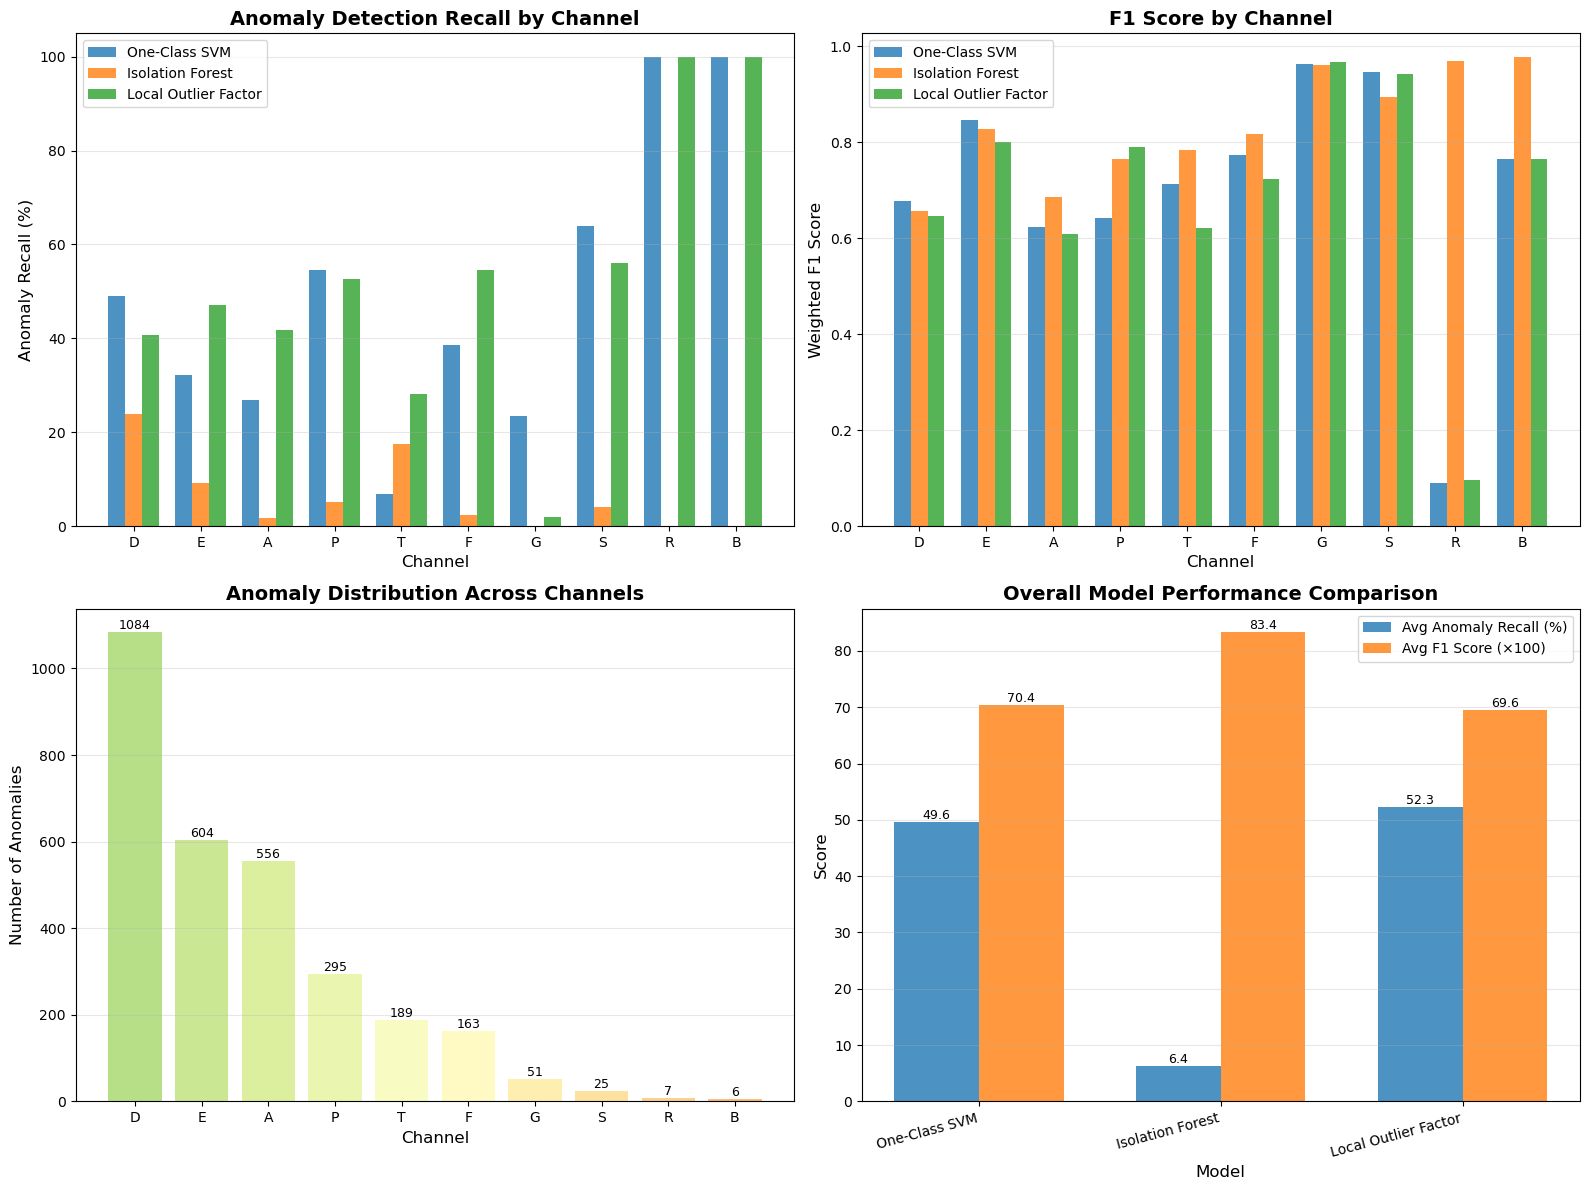

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Anomaly Recall by Channel
ax1 = axes[0, 0]
channels_sorted = sorted(channel_names, key=lambda x: svm_results[x]['n_anomalies'], reverse=True)
x = np.arange(len(channels_sorted))
width = 0.25

svm_recalls = [svm_results[ch]['anomaly_recall'] * 100 for ch in channels_sorted]
if_recalls = [if_results[ch]['anomaly_recall'] * 100 for ch in channels_sorted]
lof_recalls = [lof_results[ch]['anomaly_recall'] * 100 for ch in channels_sorted]

ax1.bar(x - width, svm_recalls, width, label='One-Class SVM', alpha=0.8)
ax1.bar(x, if_recalls, width, label='Isolation Forest', alpha=0.8)
ax1.bar(x + width, lof_recalls, width, label='Local Outlier Factor', alpha=0.8)

ax1.set_xlabel('Channel', fontsize=12)
ax1.set_ylabel('Anomaly Recall (%)', fontsize=12)
ax1.set_title('Anomaly Detection Recall by Channel', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(channels_sorted)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. F1 Score by Channel
ax2 = axes[0, 1]
svm_f1s = [svm_results[ch]['f1'] for ch in channels_sorted]
if_f1s = [if_results[ch]['f1'] for ch in channels_sorted]
lof_f1s = [lof_results[ch]['f1'] for ch in channels_sorted]

ax2.bar(x - width, svm_f1s, width, label='One-Class SVM', alpha=0.8)
ax2.bar(x, if_f1s, width, label='Isolation Forest', alpha=0.8)
ax2.bar(x + width, lof_f1s, width, label='Local Outlier Factor', alpha=0.8)

ax2.set_xlabel('Channel', fontsize=12)
ax2.set_ylabel('Weighted F1 Score', fontsize=12)
ax2.set_title('F1 Score by Channel', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(channels_sorted)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Anomaly Distribution
ax3 = axes[1, 0]
anomaly_counts = [svm_results[ch]['n_anomalies'] for ch in channels_sorted]
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(channels_sorted)))

bars = ax3.bar(channels_sorted, anomaly_counts, color=colors, alpha=0.8)
ax3.set_xlabel('Channel', fontsize=12)
ax3.set_ylabel('Number of Anomalies', fontsize=12)
ax3.set_title('Anomaly Distribution Across Channels', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, anomaly_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontsize=9)

# 4. Model Performance Summary (Radar/Spider Chart alternative - Bar Chart)
ax4 = axes[1, 1]
models = ['One-Class SVM', 'Isolation Forest', 'Local Outlier Factor']
avg_recalls = [svm_avg_recall * 100, if_avg_recall * 100, lof_avg_recall * 100]
avg_f1s_scaled = [svm_avg_f1 * 100, if_avg_f1 * 100, lof_avg_f1 * 100]

x_pos = np.arange(len(models))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, avg_recalls, width, label='Avg Anomaly Recall (%)', alpha=0.8)
bars2 = ax4.bar(x_pos + width/2, avg_f1s_scaled, width, label='Avg F1 Score (×100)', alpha=0.8)

ax4.set_xlabel('Model', fontsize=12)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Overall Model Performance Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models, rotation=15, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()